# Analyzing silent_churn_v1.json model

<Figure size 1000x600 with 0 Axes>

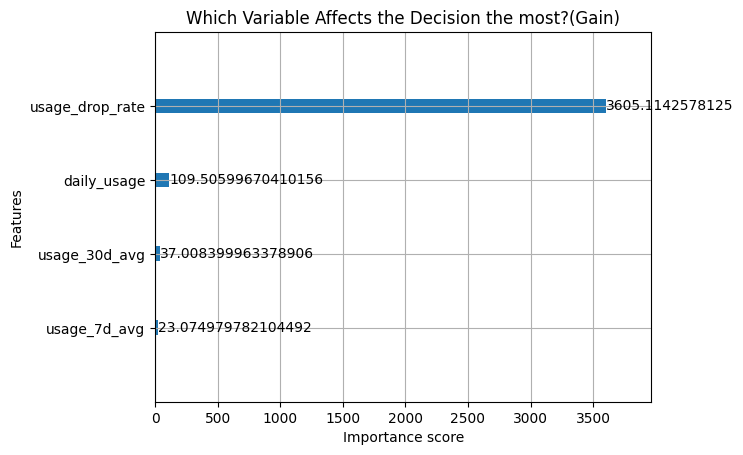

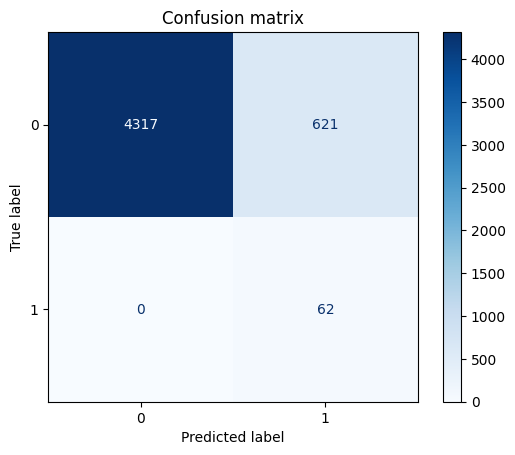

In [2]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys

sys.path.append('..')
from src.databases.db_loader import get_engine

model= xgb.XGBClassifier()
model.load_model('../models/silent_churn_v1.json')

engine = get_engine()
df = pd.read_sql("SELECT * FROM labeled_features LIMIT 5000",engine)
X = df.drop(columns=['account_id','usage_date','target'])
y = df['target']

# gain

plt.figure(figsize=(10,6))

xgb.plot_importance(model, importance_type= 'gain',max_num_features=10)
plt.title("Which Variable Affects the Decision the most?(Gain)")
plt.show()


# Confusion matrix

y_pred = model.predict(X)
cm = confusion_matrix(y,y_pred)
disp = confusion_matrix(y ,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()


--- Threshold: 0.85 ---
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     67938
           1       0.18      0.71      0.28      1271

    accuracy                           0.93     69209
   macro avg       0.59      0.83      0.62     69209
weighted avg       0.98      0.93      0.95     69209



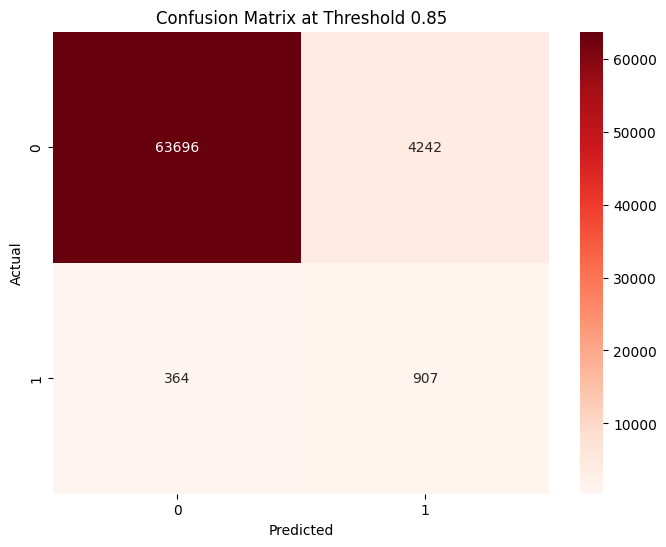

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sys
import os

# Add project root directory to path
sys.path.append('..')
from src.databases.db_loader import get_engine

# 1. Load the model
model = xgb.XGBClassifier()
model.load_model('../models/silent_churn_v1.json')

# 2. Fetch the data (Analyzing the full dataset is healthier)
engine = get_engine()
df = pd.read_sql("SELECT * FROM labeled_features", engine)

# 3. Split the data (Using stratify as in model training)
X = df.drop(columns=['account_id', 'usage_date', 'target'])
y = df['target']

_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Get prediction probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Custom threshold
custom_threshold = 0.85
y_pred_custom = (y_probs >= custom_threshold).astype(int)

print(f"--- Threshold: {custom_threshold} ---")
print(classification_report(y_test, y_pred_custom))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_custom = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix at Threshold {custom_threshold}')
plt.show()